In [ ]:
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
from google.colab import drive

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/Capstone Project - LAI25-SM055/BISpeak/Dataset/bispeak_augmented_combined_final.zip"
extract_path = "/content/bispeak"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset berhasil diekstrak ke: {extract_path}")

Dataset berhasil diekstrak ke: /content/bispeak


Memuat dataset training...
Found 37800 files belonging to 126 classes.
Dataset training dimuat.
Memuat dataset validasi...
Found 2062 files belonging to 126 classes.
Dataset validasi dimuat.
Memuat dataset test...
Found 2062 files belonging to 126 classes.
Dataset test dimuat.
Ditemukan 126 kelas: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'ambil', 'anjing', 'apa', 'atas', 'ayah', 'bantu', 'bau', 'bawah', 'berdoa', 'berhenti', 'berjalan', 'bermain', 'berpikir', 'bertemu', 'betul', 'bingung', 'bisindo', 'bodoh', 'buat', 'cantik', 'cinta', 'egois', 'halo', 'hati-hati', 'hubungan', 'ibu', 'ingat', 'jangan', 'janji', 'kacamata', 'kakak', 'kakek', 'kamu', 'kanan', 'keren', 'kerja', 'kiri', 'kuat', 'kucing', 'lagi', 'laki-laki', 'lelah', 'lucu', 'maaf', 'makan', 'mandi', 'marah', 'mau', 'melihat', 'membaca', 'memukul', 'menangis', 'mendengar', 'mendorong', 'menggambar', 'menuangkan', 'menulis', 'minta', '

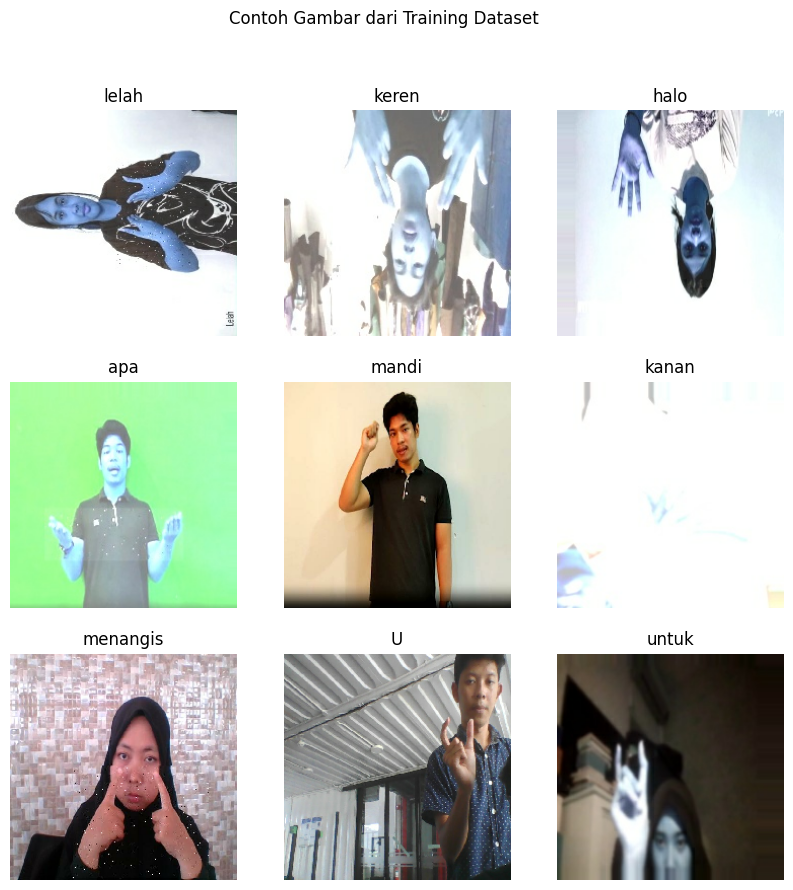

In [ ]:
# ==================================================
# BAGIAN 2: PEMUATAN DAN PERSIAPAN DATA (MODIFIKASI)
# ==================================================

# 2.3. Konfigurasi untuk Pemuatan Dataset
IMG_HEIGHT = 224  # Ukuran input default untuk EfficientNetB0
IMG_WIDTH = 224
BATCH_SIZE = 32   # Sesuaikan sesuai kemampuan memori GPU
SEED = 123        # Untuk reproduktibilitas

# Path ke direktori dataset yang sudah terpisah
train_dir = "/content/bispeak/train"
validation_dir = "/content/bispeak/val"
test_dir = "/content/bispeak/test" # Kamu juga punya folder test

# 2.4. Muat Data Training
print("Memuat dataset training...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical', # Untuk categorical_crossentropy
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True, # Data training sebaiknya di-shuffle
    seed=SEED
    # validation_split dan subset tidak diperlukan karena folder sudah terpisah
)
print("Dataset training dimuat.")

# 2.5. Muat Data Validasi
print("Memuat dataset validasi...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False, # Data validasi dan test tidak perlu di-shuffle
    seed=SEED
    # validation_split dan subset tidak diperlukan
)
print("Dataset validasi dimuat.")

# (Opsional) Muat Data Test jika akan digunakan untuk evaluasi akhir
print("Memuat dataset test...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False, # Data validasi dan test tidak perlu di-shuffle
    seed=SEED
)
print("Dataset test dimuat.")

# Dapatkan nama kelas dan jumlah kelas dari train_dataset
# Asumsi kelas di train, val, dan test konsisten
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Ditemukan {num_classes} kelas: {class_names}")

# 2.6. Optimasi Performa Dataset
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE) # Optimasi juga dataset test
print("Dataset training, validasi, dan test dioptimasi untuk performa (cache dan prefetch).")

# (Opsional) Tampilkan beberapa contoh gambar dari batch training
# Pastikan plt sudah diimpor: import matplotlib.pyplot as plt
# Pastikan tf sudah diimpor: import tensorflow as tf
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(min(9, BATCH_SIZE)): # Tampilkan maksimal 9 gambar atau sejumlah batch size jika < 9
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # labels adalah one-hot encoded, jadi kita ambil index dari nilai max
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")
plt.suptitle("Contoh Gambar dari Training Dataset")
plt.show()

Memuat base model EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model dimuat.
Bobot base model dibekukan (trainable = False).
Model kustom dibangun.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 126)            │       161,406 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,210,977 (16.06 MB)

 Trainable params: 161,406 (630.49 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Mengompilasi model dengan learning rate awal: 0.001
Model dikompilasi.
Memulai training awal selama 20 epoch...
Epoch 1/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4660 - loss: 2.5452
Epoch 1: val_accuracy improved from -inf to 0.95053, saving model to bisindo_efficientnet_initial_best.weights.h5
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 126s 86ms/step - accuracy: 0.4662 - loss: 2.5444 - val_accuracy: 0.9505 - val_loss: 0.3480
Epoch 2/20
1181/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8427 - loss: 0.7102
Epoch 2: val_accuracy improved from 0.95053 to 0.97381, saving model to bisindo_efficientnet_initial_best.weights.h5
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 63s 32ms/step - accuracy: 0.8427 - loss: 0.7101 - val_accuracy: 0.9738 - val_loss: 0.1830
Epoch 3/20
1181/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8849 - loss: 0.5042
Epoch 3: val_accuracy improved from 0.97381 to 0.98157, saving model to bisindo_efficientnet_initial_best.weights.h5
1182/1182 ━━━━━━━━━━━━━━━━━━━━

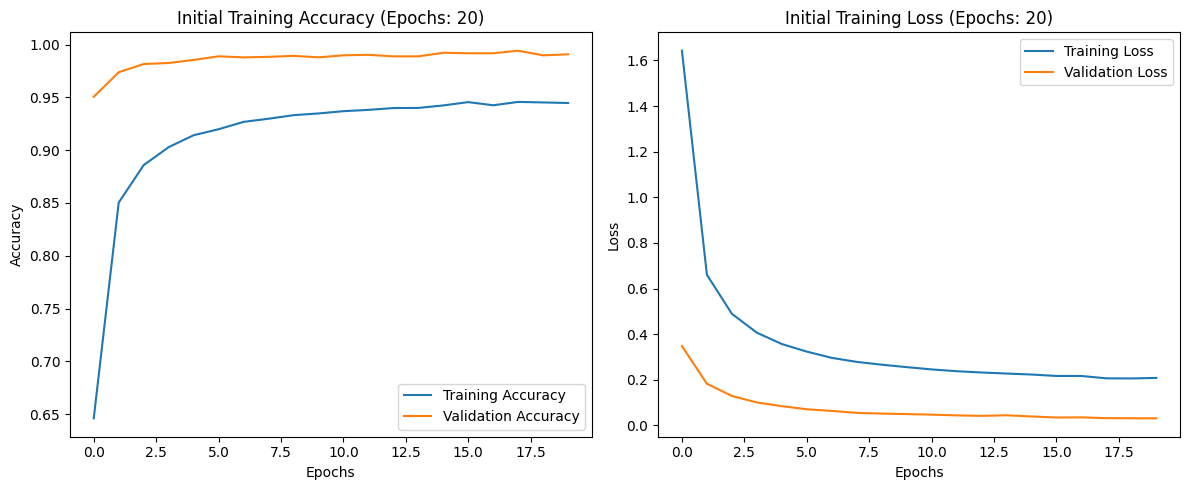


Mengevaluasi model awal pada data test...
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9886 - loss: 0.0466
Test Loss (Initial Model): 0.0434
Test Accuracy (Initial Model): 98.93%


In [ ]:
# Muat Base Model (EfficientNetB0)
print("Memuat base model EfficientNetB0...")
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
print("Base model dimuat.")


base_model.trainable = False
print("Bobot base model dibekukan (trainable = False).")

# Bangun Model Kustom di Atas Base Model
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="input_layer")

x = inputs

x = base_model(x, training=False) # Set training=False karena lapisan base_model dibekukan
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool")(x) # Mengubah output fitur menjadi vektor flat
x = tf.keras.layers.Dropout(0.3, name="dropout_layer")(x) # Dropout untuk regularisasi, mengurangi overfitting
outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name="output_layer")(x) # Lapisan output dengan unit sebanyak num_classes dan aktivasi softmax untuk klasifikasi multi-kelas

model = tf.keras.Model(inputs, outputs)
print("Model kustom dibangun.")

model.summary() # Menampilkan ringkasan arsitektur model

# Kompilasi Model
LEARNING_RATE_INITIAL = 0.001 # Learning rate awal
print(f"Mengompilasi model dengan learning rate awal: {LEARNING_RATE_INITIAL}")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_INITIAL),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model dikompilasi.")

# Latih Model (Tahap Transfer Learning Awal)
EPOCHS_INITIAL = 20
print(f"Memulai training awal selama {EPOCHS_INITIAL} epoch...")

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='bisindo_efficientnet_initial_best.weights.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

history_initial = model.fit(
    train_dataset,
    epochs=EPOCHS_INITIAL,
    validation_data=validation_dataset,
    callbacks=callbacks_list
)
print("Training awal selesai.")

acc = history_initial.history['accuracy']
val_acc = history_initial.history['val_accuracy']
loss = history_initial.history['loss']
val_loss = history_initial.history['val_loss']

# Dapatkan jumlah epoch aktual yang dijalankan (jika EarlyStopping aktif)
actual_epochs_initial = len(acc)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(actual_epochs_initial), acc, label='Training Accuracy')
plt.plot(range(actual_epochs_initial), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Initial Training Accuracy (Epochs: {actual_epochs_initial})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(actual_epochs_initial), loss, label='Training Loss')
plt.plot(range(actual_epochs_initial), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Initial Training Loss (Epochs: {actual_epochs_initial})')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout() # Agar plot tidak tumpang tindih
plt.show()

# Evaluasi Model Awal pada Data Test
print("\nMengevaluasi model awal pada data test...")
results_initial = model.evaluate(test_dataset, verbose=1)

print(f"Test Loss (Initial Model): {results_initial[0]:.4f}")
print(f"Test Accuracy (Initial Model): {results_initial[1]*100:.2f}%")

Membuat prediksi pada test_dataset...
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step
Prediksi selesai. Jumlah total prediksi: 2062
Mengumpulkan label asli dan gambar dari test_dataset...
Pengumpulan label asli dan gambar selesai. Jumlah total sampel: 2062

--- Ringkasan Prediksi pada Data Test ---
Total Data Test Diproses: 2062
Prediksi Benar (Correct): 2040
Prediksi Salah (Incorrect): 22
Akurasi Aktual pada Data Test: 98.93%


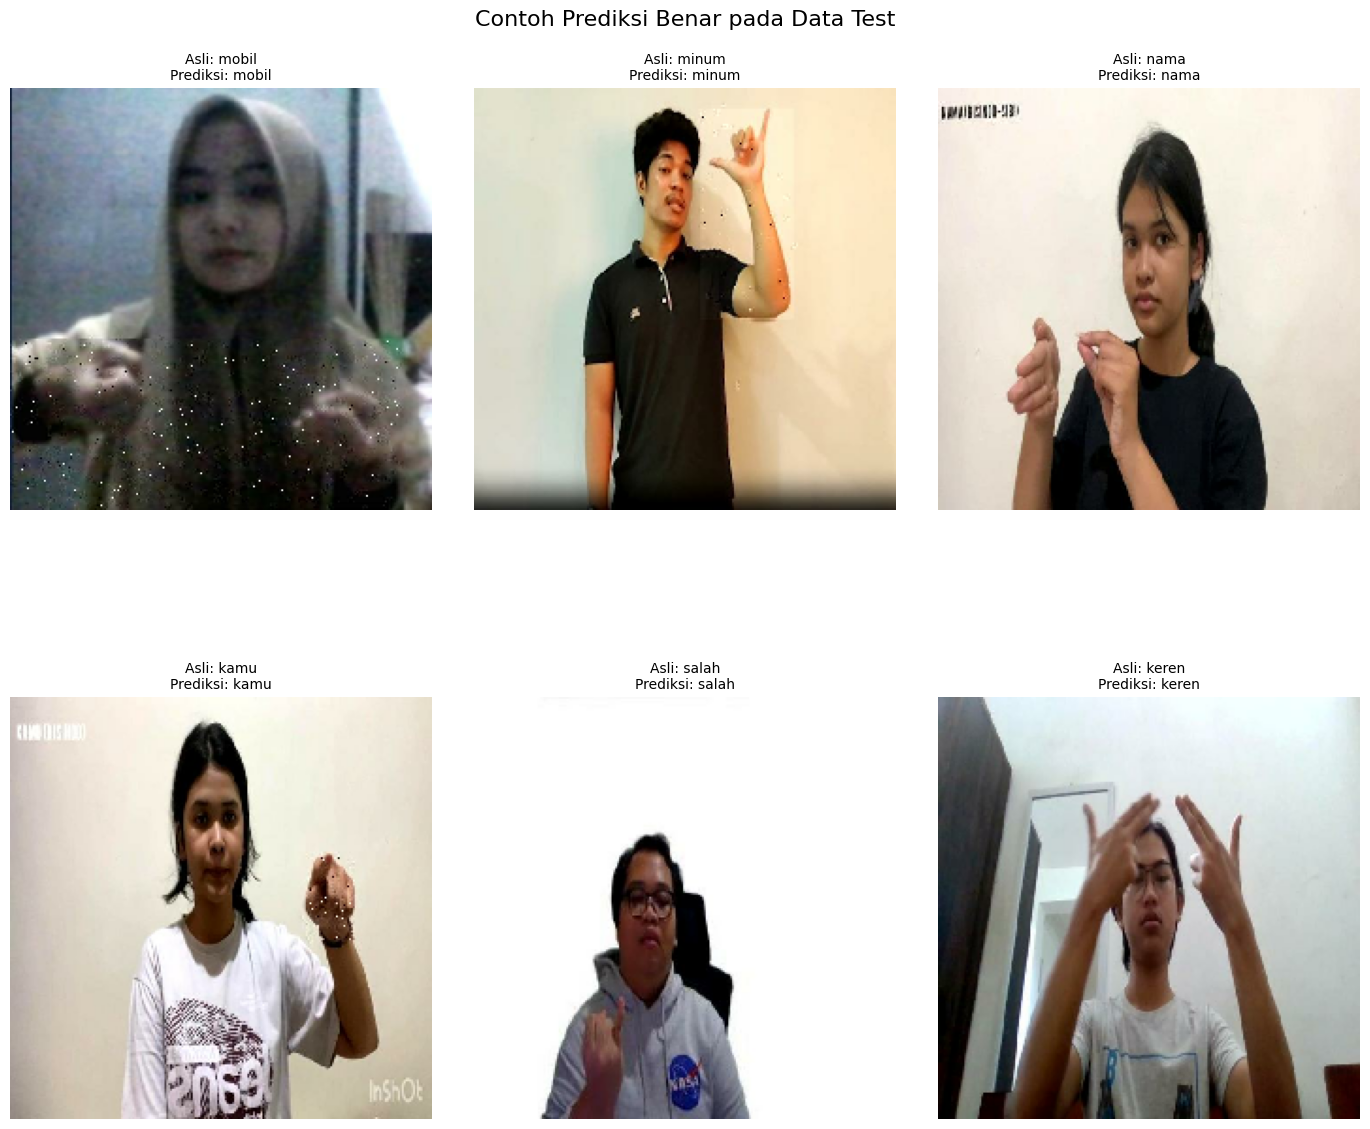

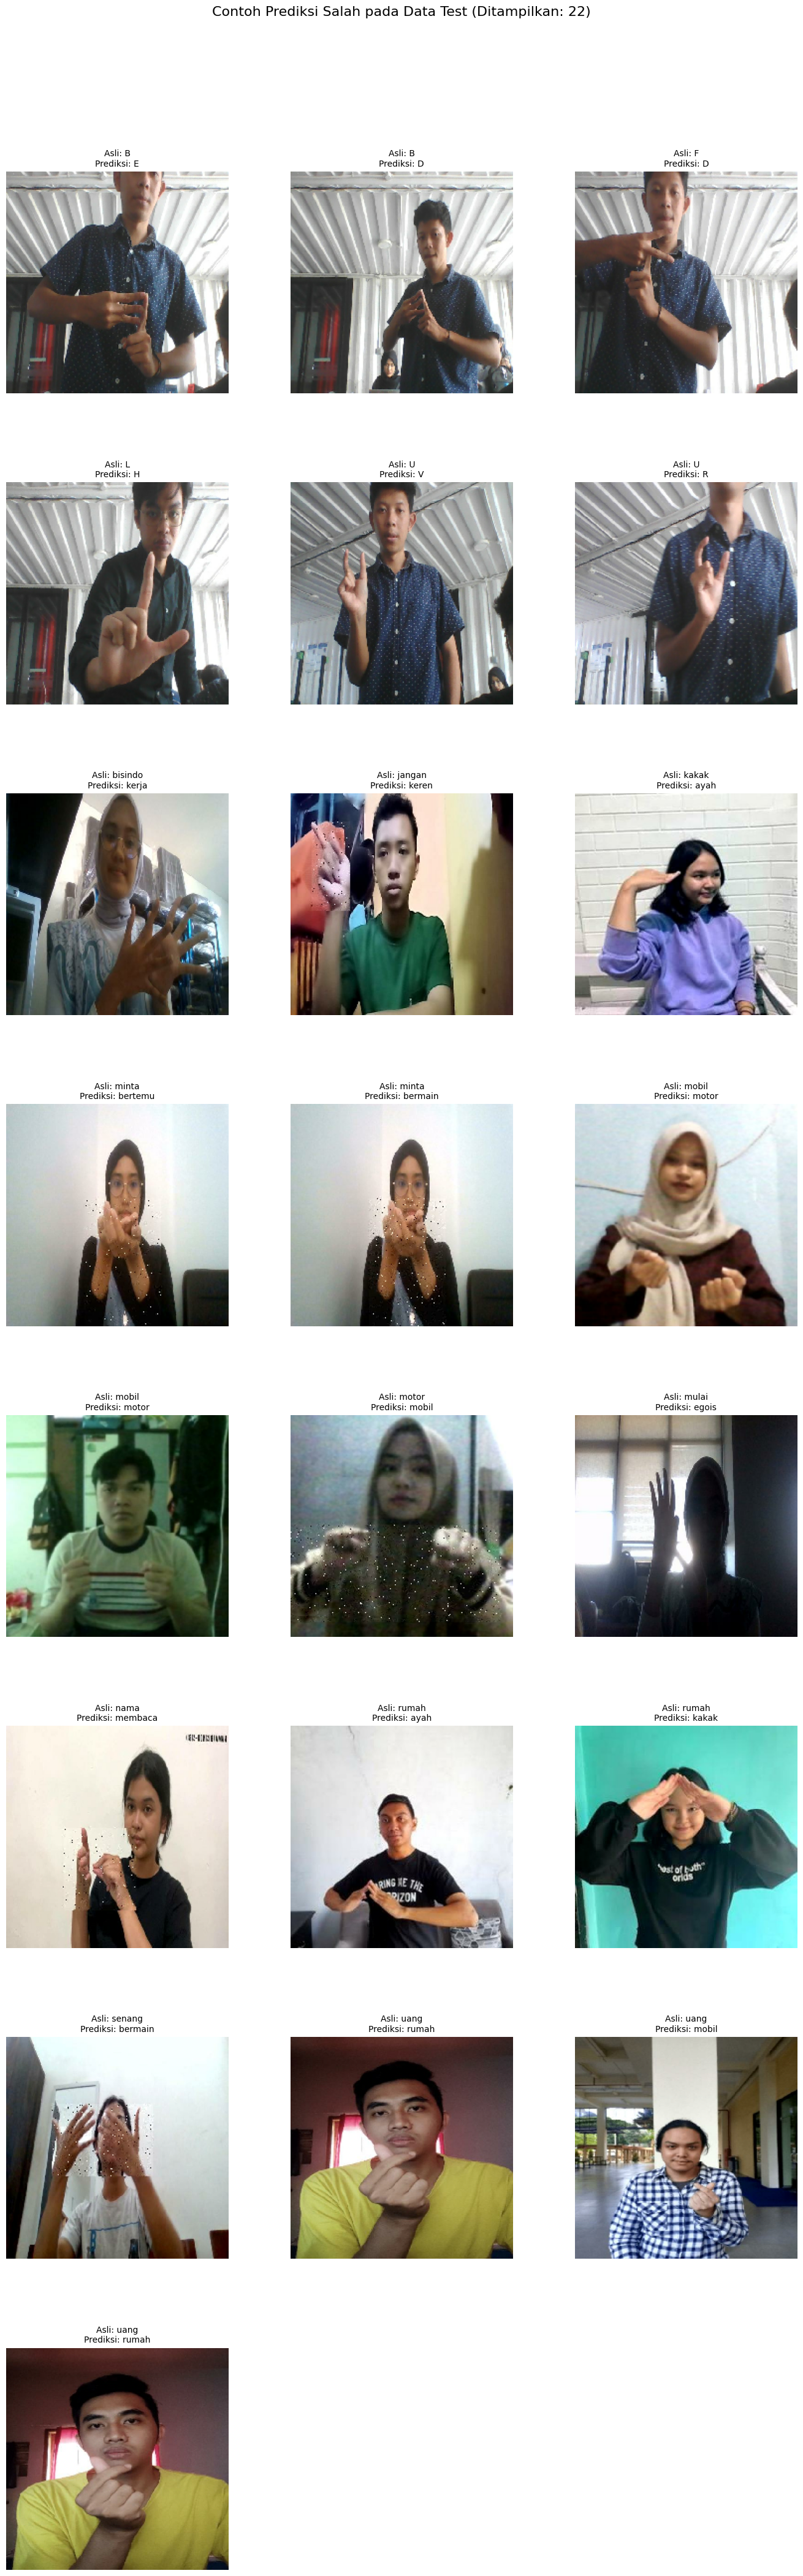

In [ ]:
# Asumsi dari langkah sebelumnya:
# - 'model' adalah objek model Keras yang sudah dilatih.
# - 'test_dataset' adalah tf.data.Dataset yang berisi data test.
# - 'class_names' adalah list yang berisi nama-nama kelas.
# - 'IMG_HEIGHT', 'IMG_WIDTH', 'BATCH_SIZE' sudah terdefinisi.
# Pastikan library yang dibutuhkan sudah diimpor:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# 1. Membuat Prediksi pada Seluruh test_dataset
print("Membuat prediksi pada test_dataset...")
predictions_probabilities = model.predict(test_dataset)
predicted_class_indices = np.argmax(predictions_probabilities, axis=1)
predicted_class_names = [class_names[i] for i in predicted_class_indices]
print(f"Prediksi selesai. Jumlah total prediksi: {len(predicted_class_names)}")

# 2. Mengumpulkan Label Asli dan Gambar dari test_dataset
true_labels_list_indices = []
image_list = []

print("Mengumpulkan label asli dan gambar dari test_dataset...")
for images_batch, labels_batch in test_dataset:
    true_labels_list_indices.extend(np.argmax(labels_batch.numpy(), axis=1))
    image_list.extend(images_batch.numpy())

true_class_names = [class_names[i] for i in true_labels_list_indices]
print(f"Pengumpulan label asli dan gambar selesai. Jumlah total sampel: {len(true_class_names)}")

# Sanity check
if len(predicted_class_names) != len(true_class_names):
    print(f"PERINGATAN: Jumlah prediksi ({len(predicted_class_names)}) tidak sama dengan jumlah label asli ({len(true_class_names)}).")
    min_len = min(len(predicted_class_names), len(true_class_names))
    predicted_class_names = predicted_class_names[:min_len]
    true_class_names = true_class_names[:min_len]
    image_list = image_list[:min_len]

# 3. Membandingkan Prediksi dengan Label Asli
correct_predictions_info = []
incorrect_predictions_info = []
total_correct = 0
total_incorrect = 0

for i in range(len(predicted_class_names)):
    img = image_list[i]
    true_label = true_class_names[i]
    predicted_label = predicted_class_names[i]

    if true_label == predicted_label:
        total_correct += 1
        correct_predictions_info.append({
            "image": img, "true_label": true_label, "predicted_label": predicted_label
        })
    else:
        total_incorrect += 1
        incorrect_predictions_info.append({
            "image": img, "true_label": true_label, "predicted_label": predicted_label
        })

print(f"\n--- Ringkasan Prediksi pada Data Test ---")
print(f"Total Data Test Diproses: {len(true_class_names)}")
print(f"Prediksi Benar (Correct): {total_correct}")
print(f"Prediksi Salah (Incorrect): {total_incorrect}")

if len(true_class_names) > 0:
    accuracy_on_test = (total_correct / len(true_class_names)) * 100
    print(f"Akurasi Aktual pada Data Test: {accuracy_on_test:.2f}%")
else:
    print("Tidak ada data test untuk dihitung akurasinya.")

# 4. Fungsi untuk Menampilkan Contoh Prediksi (Dengan Penyesuaian Layout)
def display_prediction_examples(prediction_info_list, title, num_to_display=6):
    if not prediction_info_list:
        print(f"\nTidak ada contoh untuk ditampilkan: {title}")
        return

    if len(prediction_info_list) > num_to_display:
        samples_to_display = random.sample(prediction_info_list, num_to_display)
    else:
        samples_to_display = prediction_info_list

    if not samples_to_display:
        print(f"\nTidak ada contoh untuk ditampilkan setelah seleksi: {title}")
        return

    num_actual_display = len(samples_to_display)
    cols = min(3, num_actual_display)
    rows = (num_actual_display + cols - 1) // cols

    plt.figure(figsize=(5 * cols, 5.5 * rows + 1))
    plt.suptitle(title, fontsize=16, y=0.98)

    for i, info in enumerate(samples_to_display):
        plt.subplot(rows, cols, i + 1)
        img_display = info["image"]
        if img_display.dtype == np.float32 or img_display.dtype == np.float64:
            if img_display.max() > 1.0:
                img_display = img_display.astype("uint8")

        plt.imshow(img_display)
        plt.title(f"Asli: {info['true_label']}\nPrediksi: {info['predicted_label']}", fontsize=10)
        plt.axis("off")

    plt.subplots_adjust(
        left=0.05, right=0.95, bottom=0.05, top=0.92,
        hspace=0.4, wspace=0.1
    )
    plt.show()

# Tampilkan contoh prediksi yang benar (misalnya 6 contoh)
display_prediction_examples(correct_predictions_info, "Contoh Prediksi Benar pada Data Test", num_to_display=6)

# Tampilkan semua prediksi yang salah jika jumlahnya sedikit (misalnya <= 19), atau sampel jika banyak
jumlah_salah_untuk_ditampilkan = len(incorrect_predictions_info) # Tampilkan semua yang salah
# Jika ingin membatasi, ganti dengan angka, misal: jumlah_salah_untuk_ditampilkan = min(19, len(incorrect_predictions_info))

display_prediction_examples(incorrect_predictions_info,
                            f"Contoh Prediksi Salah pada Data Test (Ditampilkan: {min(jumlah_salah_untuk_ditampilkan, len(incorrect_predictions_info))})",
                            num_to_display=jumlah_salah_untuk_ditampilkan)


Silakan unggah satu atau beberapa file gambar (.jpg, .jpeg, .png) untuk diprediksi.


Saving A.2d53f1a4-e263-11ed-a0c4-001a7dda7115.jpg to A.2d53f1a4-e263-11ed-a0c4-001a7dda7115.jpg

--- Memproses prediksi untuk gambar: A.2d53f1a4-e263-11ed-a0c4-001a7dda7115.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


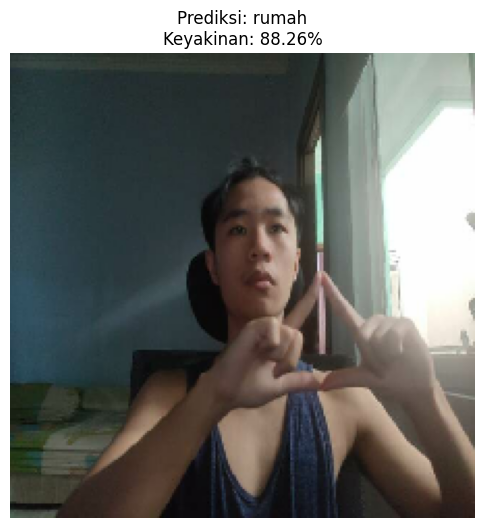

Analisis untuk gambar: A.2d53f1a4-e263-11ed-a0c4-001a7dda7115.jpg
Kelas yang Diprediksi: rumah
Tingkat Keyakinan: 88.26%

Probabilitas untuk setiap kelas:
  - A: 0.00%
  - B: 0.00%
  - C: 0.00%
  - D: 0.00%
  - E: 0.00%
  - F: 0.00%
  - G: 0.00%
  - H: 0.00%
  - I: 0.00%
  - J: 0.00%
  - K: 0.00%
  - L: 0.00%
  - M: 0.00%
  - N: 0.00%
  - O: 0.00%
  - P: 0.00%
  - Q: 0.00%
  - R: 0.00%
  - S: 0.00%
  - T: 0.01%
  - U: 0.03%
  - V: 0.00%
  - W: 0.02%
  - X: 0.00%
  - Y: 0.03%
  - Z: 0.00%
  - ambil: 0.00%
  - anjing: 0.00%
  - apa: 0.00%
  - atas: 0.00%
  - ayah: 0.02%
  - bantu: 0.00%
  - bau: 0.00%
  - bawah: 0.00%
  - berdoa: 0.00%
  - berhenti: 0.02%
  - berjalan: 0.00%
  - bermain: 0.07%
  - berpikir: 0.00%
  - bertemu: 0.01%
  - betul: 0.00%
  - bingung: 0.00%
  - bisindo: 0.00%
  - bodoh: 0.00%
  - buat: 0.09%
  - cantik: 0.00%
  - cinta: 0.00%
  - egois: 0.27%
  - halo: 0.00%
  - hati-hati: 0.00%
  - hubungan: 0.00%
  - ibu: 0.00%
  - ingat: 0.00%
  - jangan: 0.00%
  - janji: 0.

In [ ]:
# Asumsi dari langkah sebelumnya:
# - 'model' adalah objek model Keras yang sudah dilatih.
# - 'class_names' adalah list yang berisi nama-nama kelas.
# - 'IMG_HEIGHT', 'IMG_WIDTH' sudah terdefinisi.
# Pastikan library yang dibutuhkan sudah diimpor:
from google.colab import files
from tensorflow.keras.preprocessing import image as keras_image_utils
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

def predict_uploaded_image(model_to_use, uploaded_file_path, target_img_height, target_img_width, c_names):
    """
    Fungsi untuk memprediksi kelas dari satu gambar yang diunggah.
    """
    try:
        img = keras_image_utils.load_img(uploaded_file_path, target_size=(target_img_height, target_img_width))
        img_array = keras_image_utils.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        # img_batch_processed = tf.keras.applications.efficientnet.preprocess_input(img_batch.copy()) # Aktifkan jika menggunakan preprocess_input saat training
        img_batch_processed = img_batch # Jika tidak ada preprocessing tambahan khusus

        predictions_prob = model_to_use.predict(img_batch_processed)
        predicted_index = np.argmax(predictions_prob[0])
        predicted_label = c_names[predicted_index]
        predicted_confidence = predictions_prob[0][predicted_index] * 100

        plt.figure(figsize=(6, 7))
        plt.imshow(img)
        plt.title(f"Prediksi: {predicted_label}\nKeyakinan: {predicted_confidence:.2f}%", fontsize=12)
        plt.axis("off")
        plt.show()

        print(f"Analisis untuk gambar: {os.path.basename(uploaded_file_path)}")
        print(f"Kelas yang Diprediksi: {predicted_label}")
        print(f"Tingkat Keyakinan: {predicted_confidence:.2f}%")
        print("\nProbabilitas untuk setiap kelas:")
        for i, label in enumerate(c_names):
            print(f"  - {label}: {predictions_prob[0][i]*100:.2f}%")

    except FileNotFoundError:
        print(f"Error: File gambar tidak ditemukan di '{uploaded_file_path}'")
    except Exception as e:
        print(f"Terjadi kesalahan saat memproses gambar '{uploaded_file_path}': {e}")
        import traceback
        traceback.print_exc()

# --- Kode untuk mengunggah file di Google Colab ---
print("\nSilakan unggah satu atau beberapa file gambar (.jpg, .jpeg, .png) untuk diprediksi.")
uploaded = files.upload()

if not uploaded:
    print("\nTidak ada file yang diunggah.")
else:
    if 'model' not in globals() or 'class_names' not in globals() or \
       'IMG_HEIGHT' not in globals() or 'IMG_WIDTH' not in globals():
        print("\nKESALAHAN: Variabel 'model', 'class_names', 'IMG_HEIGHT', atau 'IMG_WIDTH' belum terdefinisi.")
    else:
        for file_name_key in uploaded.keys():
            temp_file_path = file_name_key
            print(f"\n--- Memproses prediksi untuk gambar: {temp_file_path} ---")
            predict_uploaded_image(model, temp_file_path, IMG_HEIGHT, IMG_WIDTH, class_names)
            # (Opsional) Hapus file sementara setelah prediksi jika diinginkan
            # try:
            #     os.remove(temp_file_path)
            # except OSError:
            #     pass # Abaikan jika gagal dihapus

### fine tuning


--- Memulai Proses Fine-Tuning Model ---
Fine-tuning: 30 lapisan teratas dari base_model akan dilatih.
Total lapisan di base_model: 238

Model dikompilasi ulang untuk fine-tuning dengan learning rate: 1e-05


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 126)            │       161,406 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,210,977 (16.06 MB)

 Trainable params: 1,657,566 (6.32 MB)

 Non-trainable params: 2,553,411 (9.74 MB)


Melanjutkan training untuk fine-tuning dari epoch 20 hingga 35...
Epoch 21/35
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8648 - loss: 0.4793
Epoch 21: val_accuracy improved from -inf to 0.99079, saving model to bisindo_efficientnet_finetuned_best.weights.h5
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 115s 71ms/step - accuracy: 0.8648 - loss: 0.4793 - val_accuracy: 0.9908 - val_loss: 0.0538
Epoch 22/35
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9131 - loss: 0.3177
Epoch 22: val_accuracy improved from 0.99079 to 0.99176, saving model to bisindo_efficientnet_finetuned_best.weights.h5
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.9131 - loss: 0.3176 - val_accuracy: 0.9918 - val_loss: 0.0405
Epoch 23/35
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9328 - loss: 0.2600
Epoch 23: val_accuracy improved from 0.99176 to 0.99273, saving model to bisindo_efficientnet_finetuned_best.weights.h5
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.9328

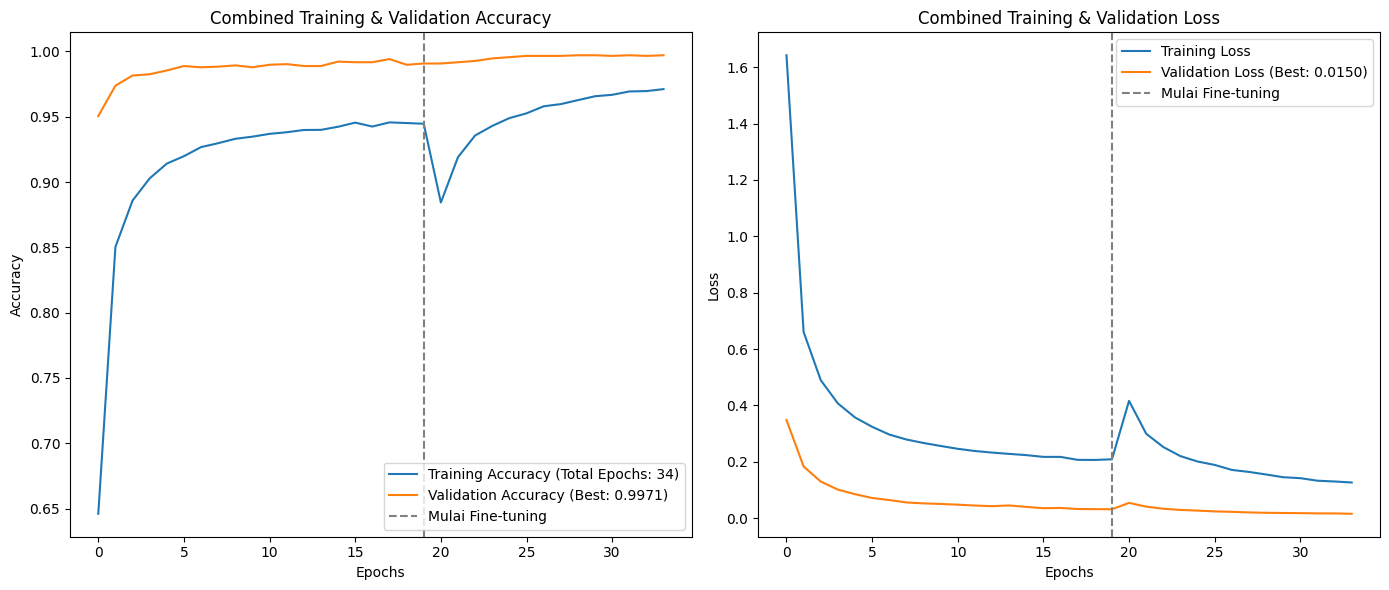


Mengevaluasi model yang sudah di-fine-tune pada data test...
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9966 - loss: 0.0240
Test Loss (Fine-tuned Model): 0.0284
Test Accuracy (Fine-tuned Model): 99.37%


In [ ]:
# Asumsi dari langkah sebelumnya:
# - 'model': Model Keras yang sudah melalui training awal.
# - 'base_model': Bagian EfficientNetB0 dari 'model'.
# - 'history_initial': Objek history dari training awal.
# - 'train_dataset', 'validation_dataset', 'test_dataset': Sudah siap.
# - 'actual_epochs_initial': Jumlah epoch aktual dari training awal (misal, len(history_initial.history['accuracy'])).
# - 'class_names', 'num_classes', 'IMG_HEIGHT', 'IMG_WIDTH': Sudah terdefinisi.
# - Library matplotlib.pyplot (plt) dan tensorflow (tf) sudah diimpor.

# --- Memulai Proses Fine-Tuning ---
print("\n--- Memulai Proses Fine-Tuning Model ---")

# 1. Cairkan (Unfreeze) base_model atau sebagian lapisannya
base_model.trainable = True

# Tentukan berapa banyak lapisan dari *atas* (akhir) base_model yang ingin kamu latih.
# Semakin sedikit data yang kamu miliki, atau semakin mirip datasetmu dengan ImageNet,
# semakin sedikit lapisan yang sebaiknya kamu cairkan.
# EfficientNetB0 memiliki banyak lapisan (sekitar 230-an).
# Mari kita coba cairkan (unfreeze) 30 lapisan teratas sebagai contoh awal.
# Kamu bisa bereksperimen dengan angka ini.
layers_to_fine_tune = 30
fine_tune_from_layer_index = len(base_model.layers) - layers_to_fine_tune

for i, layer in enumerate(base_model.layers):
    if i < fine_tune_from_layer_index:
        layer.trainable = False  # Bekukan lapisan-lapisan awal
    else:
        layer.trainable = True   # Cairkan lapisan-lapisan akhir untuk fine-tuning
        # print(f"Layer '{layer.name}' (index {i}) di-set trainable untuk fine-tuning.")

print(f"Fine-tuning: {layers_to_fine_tune} lapisan teratas dari base_model akan dilatih.")
print(f"Total lapisan di base_model: {len(base_model.layers)}")

# 2. Kompilasi ulang model dengan learning rate yang SANGAT KECIL
# Ini krusial agar tidak merusak bobot pra-latih secara drastis.
LEARNING_RATE_FINETUNE = 0.00001 # Contoh: 1e-5. Bisa juga 5e-6 atau 2e-6. Perlu eksperimen.

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_FINETUNE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print(f"\nModel dikompilasi ulang untuk fine-tuning dengan learning rate: {LEARNING_RATE_FINETUNE}")
model.summary() # Perhatikan jumlah 'Trainable params' sekarang sudah bertambah.

# 3. Lanjutkan training (proses fine-tuning)
EPOCHS_FINETUNE = 15  # Jumlah epoch untuk fine-tuning. Bisa lebih sedikit atau lebih banyak.
                      # Pantau val_loss dan val_accuracy dengan cermat.

# Dapatkan jumlah epoch aktual dari training awal
if 'history_initial' in globals() and hasattr(history_initial, 'history') and 'accuracy' in history_initial.history:
    actual_epochs_initial = len(history_initial.history['accuracy'])
else:
    print("PERINGATAN: 'history_initial' tidak ditemukan atau tidak valid. Mengasumsikan 0 epoch awal.")
    actual_epochs_initial = 0 # Default jika history awal tidak ada

total_epochs_after_finetune = actual_epochs_initial + EPOCHS_FINETUNE

# Callback untuk fine-tuning (bisa sama atau berbeda dari training awal)
callbacks_list_finetune = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', # Atau 'val_loss'
        patience=5,             # Patience bisa lebih sensitif (lebih kecil) untuk fine-tuning
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='bisindo_efficientnet_finetuned_best.weights.h5', # Nama file berbeda
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True, # Hanya simpan bobot
        verbose=1
    )
]

print(f"\nMelanjutkan training untuk fine-tuning dari epoch {actual_epochs_initial} hingga {total_epochs_after_finetune}...")
history_finetune = model.fit(
    train_dataset,
    epochs=total_epochs_after_finetune,
    initial_epoch=actual_epochs_initial, # PENTING: Melanjutkan dari epoch sebelumnya
    validation_data=validation_dataset,
    callbacks=callbacks_list_finetune
)
print("Fine-tuning selesai.")

# (Opsional) Muat bobot terbaik dari proses fine-tuning jika ModelCheckpoint digunakan
# if os.path.exists('bisindo_efficientnet_finetuned_best.weights.h5'):
# print("Memuat bobot terbaik dari fine-tuning...")
# model.load_weights('bisindo_efficientnet_finetuned_best.weights.h5')


# 4. Visualisasi hasil training gabungan (initial + fine-tune)
acc_initial = history_initial.history.get('accuracy', []) if 'history_initial' in globals() and hasattr(history_initial, 'history') else []
val_acc_initial = history_initial.history.get('val_accuracy', []) if 'history_initial' in globals() and hasattr(history_initial, 'history') else []
loss_initial = history_initial.history.get('loss', []) if 'history_initial' in globals() and hasattr(history_initial, 'history') else []
val_loss_initial = history_initial.history.get('val_loss', []) if 'history_initial' in globals() and hasattr(history_initial, 'history') else []

acc_finetune = history_finetune.history.get('accuracy', [])
val_acc_finetune = history_finetune.history.get('val_accuracy', [])
loss_finetune = history_finetune.history.get('loss', [])
val_loss_finetune = history_finetune.history.get('val_loss', [])

# Gabungkan history untuk plot yang berkelanjutan
combined_acc = acc_initial + acc_finetune
combined_val_acc = val_acc_initial + val_acc_finetune
combined_loss = loss_initial + loss_finetune
combined_val_loss = val_loss_initial + val_loss_finetune
actual_total_epochs_combined = len(combined_acc)

if actual_total_epochs_combined > 0 : # Hanya plot jika ada data history
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(actual_total_epochs_combined), combined_acc, label=f'Training Accuracy (Total Epochs: {actual_total_epochs_combined})')
    plt.plot(range(actual_total_epochs_combined), combined_val_acc, label=f'Validation Accuracy (Best: {max(combined_val_acc, default=0):.4f})')
    # Tandai titik di mana fine-tuning dimulai
    if actual_epochs_initial > 0 and actual_epochs_initial < actual_total_epochs_combined:
        plt.axvline(x=actual_epochs_initial -1 , color='gray', linestyle='--', label='Mulai Fine-tuning')
    plt.legend(loc='lower right')
    plt.title('Combined Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(actual_total_epochs_combined), combined_loss, label='Training Loss')
    plt.plot(range(actual_total_epochs_combined), combined_val_loss, label=f'Validation Loss (Best: {min(combined_val_loss, default=float("inf")):.4f})')
    if actual_epochs_initial > 0 and actual_epochs_initial < actual_total_epochs_combined:
        plt.axvline(x=actual_epochs_initial -1, color='gray', linestyle='--', label='Mulai Fine-tuning')
    plt.legend(loc='upper right')
    plt.title('Combined Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada data history yang cukup untuk membuat plot.")

# 5. Evaluasi model yang sudah di-fine-tune pada data test
print("\nMengevaluasi model yang sudah di-fine-tune pada data test...")
if 'test_dataset' in globals():
    results_finetuned = model.evaluate(test_dataset, verbose=1)
    print(f"Test Loss (Fine-tuned Model): {results_finetuned[0]:.4f}")
    print(f"Test Accuracy (Fine-tuned Model): {results_finetuned[1]*100:.2f}%")
else:
    print("Variabel 'test_dataset' tidak ditemukan untuk evaluasi.")

# (Opsional) Simpan model final jika diinginkan
# model_save_path = 'bisindo_efficientnet_final_model.keras'
# model.save(model_save_path)
# print(f"Model final (setelah fine-tuning) disimpan di: {model_save_path}")

In [ ]:
# Asumsi dari langkah sebelumnya:
# - 'model' adalah objek model Keras yang sudah di-fine-tune.
# - 'test_dataset' adalah tf.data.Dataset yang berisi data test.
# - 'class_names' adalah list yang berisi nama-nama kelas.
# - Library matplotlib.pyplot (plt), numpy (np), tensorflow (tf), dan random sudah diimpor.

# --- Membuat Prediksi pada Seluruh test_dataset ---
print("Membuat prediksi pada test_dataset dengan model yang sudah di-fine-tune...")
predictions_probabilities = model.predict(test_dataset)
predicted_class_indices = np.argmax(predictions_probabilities, axis=1)
predicted_class_names = [class_names[i] for i in predicted_class_indices]
print(f"Prediksi selesai. Jumlah total prediksi: {len(predicted_class_names)}")

# --- Mengumpulkan Label Asli dan Gambar dari test_dataset ---
true_labels_list_indices = []
image_list = []

print("Mengumpulkan label asli dan gambar dari test_dataset...")
for images_batch, labels_batch in test_dataset:
    true_labels_list_indices.extend(np.argmax(labels_batch.numpy(), axis=1))
    image_list.extend(images_batch.numpy())

true_class_names = [class_names[i] for i in true_labels_list_indices]
print(f"Pengumpulan label asli dan gambar selesai. Jumlah total sampel: {len(true_class_names)}")

# Sanity check untuk memastikan jumlahnya sama
if len(predicted_class_names) != len(true_class_names):
    print(f"PERINGATAN: Jumlah prediksi ({len(predicted_class_names)}) tidak sama dengan jumlah label asli ({len(true_class_names)}).")
    print("Menyesuaikan ke panjang minimum untuk melanjutkan analisis (mungkin ada data yang terlewat).")
    min_len = min(len(predicted_class_names), len(true_class_names))
    predicted_class_names = predicted_class_names[:min_len]
    true_class_names = true_class_names[:min_len]
    image_list = image_list[:min_len]

# --- Membandingkan Prediksi dengan Label Asli ---
correct_predictions_info = []
incorrect_predictions_info = []
total_correct = 0
total_incorrect = 0

for i in range(len(predicted_class_names)):
    img = image_list[i]
    true_label = true_class_names[i]
    predicted_label = predicted_class_names[i]

    if true_label == predicted_label:
        total_correct += 1
        correct_predictions_info.append({
            "image": img, "true_label": true_label, "predicted_label": predicted_label
        })
    else:
        total_incorrect += 1
        incorrect_predictions_info.append({
            "image": img, "true_label": true_label, "predicted_label": predicted_label
        })

print(f"\n--- Ringkasan Prediksi pada Data Test (setelah Fine-Tuning) ---")
print(f"Total Data Test Diproses: {len(true_class_names)}")
print(f"Prediksi Benar (Correct): {total_correct}")
print(f"Prediksi Salah (Incorrect): {total_incorrect}")

if len(true_class_names) > 0:
    accuracy_on_test = (total_correct / len(true_class_names)) * 100
    print(f"Akurasi Aktual pada Data Test: {accuracy_on_test:.2f}%")
else:
    print("Tidak ada data test untuk dihitung akurasinya.")

# --- Fungsi untuk Menampilkan Contoh Prediksi (Dengan Penyesuaian Layout) ---
def display_prediction_examples(prediction_info_list, title, num_to_display=6):
    if not prediction_info_list:
        print(f"\nTidak ada contoh untuk ditampilkan: {title}")
        return

    if len(prediction_info_list) > num_to_display:
        samples_to_display = random.sample(prediction_info_list, num_to_display)
    else:
        samples_to_display = prediction_info_list

    if not samples_to_display:
        print(f"\nTidak ada contoh untuk ditampilkan setelah seleksi: {title}")
        return

    num_actual_display = len(samples_to_display)
    cols = min(3, num_actual_display)
    rows = (num_actual_display + cols - 1) // cols

    plt.figure(figsize=(5 * cols, 5.5 * rows + 1.2)) # Sedikit penyesuaian figsize
    plt.suptitle(title, fontsize=16, y=0.98) # Posisi y suptitle

    for i, info in enumerate(samples_to_display):
        plt.subplot(rows, cols, i + 1)
        img_display = info["image"]
        if img_display.dtype == np.float32 or img_display.dtype == np.float64:
            if img_display.max() > 1.0:
                img_display = img_display.astype("uint8")

        plt.imshow(img_display)
        plt.title(f"Asli: {info['true_label']}\nPrediksi: {info['predicted_label']}", fontsize=10)
        plt.axis("off")

    plt.subplots_adjust(
        left=0.05, right=0.95, bottom=0.05, top=0.92, # Sesuaikan 'top' agar suptitle tidak tumpang tindih
        hspace=0.4, wspace=0.15 # hspace untuk jarak vertikal, wspace untuk horizontal
    )
    plt.show()

# --- Tampilkan Contoh Prediksi ---
# Tampilkan contoh prediksi yang benar (misalnya 6 contoh)
display_prediction_examples(correct_predictions_info,
                            "Contoh Prediksi Benar pada Data Test (Model Fine-Tuned)",
                            num_to_display=6)

# Tampilkan semua prediksi yang salah jika jumlahnya sedikit, atau sampel jika banyak
jumlah_salah_untuk_ditampilkan = len(incorrect_predictions_info)
display_prediction_examples(incorrect_predictions_info,
                            f"Prediksi Salah pada Data Test (Ditampilkan: {min(jumlah_salah_untuk_ditampilkan, len(incorrect_predictions_info))}) (Model Fine-Tuned)",
                            num_to_display=jumlah_salah_untuk_ditampilkan)

Membuat prediksi pada test_dataset dengan model yang sudah di-fine-tune...


NameError: name 'model' is not defined

In [ ]:
# Asumsi dari langkah sebelumnya:
# - 'model' adalah objek model Keras yang sudah di-fine-tune.
# - 'class_names' adalah list yang berisi nama-nama kelas.
# - 'IMG_HEIGHT', 'IMG_WIDTH' sudah terdefinisi.
# Pastikan library yang dibutuhkan sudah diimpor:
from google.colab import files
from tensorflow.keras.preprocessing import image as keras_image_utils
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # Untuk tf.expand_dims atau tf.keras.applications.efficientnet.preprocess_input
import os

def predict_single_uploaded_image(model_to_use, uploaded_file_path, target_img_height, target_img_width, c_names):
    """
    Fungsi untuk memprediksi kelas dari satu gambar yang diunggah.
    """
    try:
        # 1. Muat gambar
        img = keras_image_utils.load_img(uploaded_file_path, target_size=(target_img_height, target_img_width))

        # 2. Ubah gambar menjadi array NumPy
        img_array = keras_image_utils.img_to_array(img) # Hasilnya float32, range [0, 255]

        # 3. Tambahkan dimensi batch
        img_batch = np.expand_dims(img_array, axis=0) # (1, height, width, channels)

        # 4. (SANGAT PENTING) Pra-pemrosesan jika digunakan saat training
        # Jika kamu menggunakan tf.keras.applications.efficientnet.preprocess_input saat training,
        # WAJIB terapkan juga di sini:
        # img_batch_processed = tf.keras.applications.efficientnet.preprocess_input(img_batch.copy())
        # Jika tidak, dan modelmu menerima input [0, 255] (seperti output default
        # image_dataset_from_directory atau keras_image_utils.img_to_array), maka ini bisa dilewati.
        img_batch_processed = img_batch # Asumsi tidak ada preprocess_input eksternal khusus

        # 5. Lakukan prediksi
        predictions_prob = model_to_use.predict(img_batch_processed)

        # 6. Dapatkan kelas yang diprediksi dan keyakinannya
        predicted_index = np.argmax(predictions_prob[0])
        predicted_label = c_names[predicted_index]
        predicted_confidence = predictions_prob[0][predicted_index] * 100

        # 7. Tampilkan gambar dan hasil prediksi
        plt.figure(figsize=(6, 7))
        plt.imshow(img)
        plt.title(f"Prediksi: {predicted_label}\nKeyakinan: {predicted_confidence:.2f}%", fontsize=12)
        plt.axis("off")
        plt.show()

        print(f"Analisis untuk gambar: {os.path.basename(uploaded_file_path)}")
        print(f"Kelas yang Diprediksi: {predicted_label}")
        print(f"Tingkat Keyakinan: {predicted_confidence:.2f}%")
        print("\nProbabilitas untuk setiap kelas:")
        for i, label in enumerate(c_names):
            print(f"  - {label}: {predictions_prob[0][i]*100:.2f}%")

    except FileNotFoundError:
        print(f"Error: File gambar tidak ditemukan di '{uploaded_file_path}'")
    except Exception as e:
        print(f"Terjadi kesalahan saat memproses gambar '{uploaded_file_path}': {e}")
        import traceback
        traceback.print_exc()

# --- Kode untuk mengunggah file di Google Colab ---
print("\nSilakan unggah satu atau beberapa file gambar (.jpg, .jpeg, .png) untuk diprediksi dengan model fine-tuned.")
uploaded_user_files = files.upload() # Gunakan nama variabel berbeda agar tidak bentrok jika sel dijalankan ulang

if not uploaded_user_files:
    print("\nTidak ada file yang diunggah.")
else:
    # Pastikan variabel model, class_names, IMG_HEIGHT, IMG_WIDTH sudah ada
    if 'model' not in globals() or 'class_names' not in globals() or \
       'IMG_HEIGHT' not in globals() or 'IMG_WIDTH' not in globals():
        print("\nKESALAHAN: Variabel 'model', 'class_names', 'IMG_HEIGHT', atau 'IMG_WIDTH' belum terdefinisi.")
        print("Pastikan variabel tersebut sudah ada dari langkah training atau muat model sebelumnya.")
    else:
        for file_name_from_upload in uploaded_user_files.keys():
            # Di Colab, file yang diunggah langsung tersedia di root direktori sementara dengan namanya
            temp_file_path_for_upload = file_name_from_upload

            print(f"\n--- Memproses prediksi untuk gambar: {temp_file_path_for_upload} ---")
            predict_single_uploaded_image(model, temp_file_path_for_upload, IMG_HEIGHT, IMG_WIDTH, class_names)

            # (Opsional) Hapus file yang diunggah dari runtime Colab setelah selesai
            # try:
            #     os.remove(temp_file_path_for_upload)
            # except OSError:
            #     pass